# MLP trained on the Fashion-MNIST dataset using PyTorch

In [1]:
from torch.nn import Sequential, Flatten, Linear, ReLU, NLLLoss, LogSoftmax
from torch.optim import SGD
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torch import arange, argmax
import torch
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from math import floor
from matplotlib import pyplot as plt
import wandb
from pprint import pprint

## Login to Wandb

In [2]:
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Load best hyperparameters from the Tensorflow run

In [3]:
api = wandb.Api()
sweep = api.sweep("nsiete23/tf_mlp/sweeps/3ca45van")

best_config = sweep.best_run().config
pprint(best_config)

wandb.init(config=best_config, project='torch_mlp', name='best-mlp-torch')
config = wandb.config

wandb: Sorting runs by +summary_metrics.val_loss
wandb: Currently logged in as: v-modroczky (nsiete23). Use `wandb login --relogin` to force relogin


{'batch_size': 64,
 'dense_1': 456,
 'dense_2': 150,
 'dense_3': 132,
 'dense_4': 68,
 'epochs': 21,
 'learning_rate': 0.023615358865991583,
 'momentum': 0.06432719692244611}


## Load dataset

In [4]:
data = FashionMNIST(root='../data', download=True, transform=ToTensor())
test = FashionMNIST(root='../data', download=True, train=False, transform=ToTensor())

data_length = len(data)
validation_split = 0.2
validation_size = floor(validation_split * data_length)
batch_size = config.batch_size

validation = Subset(data, arange(validation_size))
train = Subset(data, arange(validation_size, data_length))

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(validation, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)

print(len(train))
print(len(validation))
print(len(test))

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw

48000
12000
10000


## Define fit function

In [5]:
def fit(model, train_loader, val_loader, optimizer, loss_fn, epochs, batch_size):
    history = {
        'val_loss': [],
        'val_accuracy': [],
        'loss': [],
        'accuracy': []
    }
    for epoch in range(epochs):
        train_correct = 0
        train_total = 0
        val_correct = 0
        val_total = 0
        train_loss = 0
        val_loss = 0
        
        for x_train, y_train in train_loader:
            optimizer.zero_grad()
            y_pred_dist = model(x_train)
            y_pred = argmax(y_pred_dist, axis=1)
            loss = loss_fn(y_pred_dist, y_train)
            
            train_loss += loss.item()
            train_total += len(y_train)
            train_correct += (y_pred == y_train).sum().item()
            loss.backward()
            optimizer.step()
            
        for x_val, y_val in val_loader:
            with torch.no_grad():
                y_pred_dist = model(x_val)
                y_pred = argmax(y_pred_dist, axis=1)
                loss = loss_fn(y_pred_dist, y_val)
                val_loss += loss.item()
                val_total += len(y_val)
                val_correct += (y_pred == y_val).sum().item()
                
        val_loss /= len(val_loader.dataset)/batch_size
        train_loss /= len(train_loader.dataset)/batch_size
        
        val_acc = val_correct/val_total
        train_acc = train_correct/train_total
        
        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['accuracy'].append(train_acc)
        history['val_accuracy'].append(val_acc)
        
        wandb.log({
            'loss': train_loss,
            'val_loss': val_loss,
            'accuracy': train_acc,
            'val_accuracy': val_acc,
        })
        
        print(f'Epoch {epoch + 1}/{epochs}: loss {train_loss}, val_loss {val_loss}, ' +
             f'accuracy {train_acc}, val_accuracy {val_acc}')
        
    return history

## Create model

In [6]:
mlp = Sequential(
    Flatten(),
    Linear(28 * 28, config.dense_1),
    ReLU(),
    Linear(config.dense_1, config.dense_2),
    ReLU(),
    Linear(config.dense_2, config.dense_3),
    ReLU(),
    Linear(config.dense_3, config.dense_4),
    ReLU(),
    Linear(config.dense_4, 10),
    LogSoftmax(dim=1)
)

loss = NLLLoss()
optimizer = SGD(mlp.parameters(), lr=config.learning_rate, momentum=config.momentum)

## Train model and finish Wandb run

In [7]:
history = fit(mlp, train_loader, val_loader, optimizer, loss, config.epochs, config.batch_size)
wandb.finish()

Epoch 1/21: loss 1.666782383521398, val_loss 0.9223644812901814, accuracy 0.392125, val_accuracy 0.6226666666666667
Epoch 2/21: loss 0.7819648196697235, val_loss 0.6509794081052145, accuracy 0.7032708333333333, val_accuracy 0.7631666666666667
Epoch 3/21: loss 0.6169533874591192, val_loss 0.6137381938298543, accuracy 0.7756458333333334, val_accuracy 0.7715833333333333
Epoch 4/21: loss 0.5395970204671224, val_loss 0.515213986714681, accuracy 0.8087916666666667, val_accuracy 0.82025
Epoch 5/21: loss 0.48758057167132696, val_loss 0.4527187736829122, accuracy 0.8268541666666667, val_accuracy 0.8435833333333334
Epoch 6/21: loss 0.4481572914322217, val_loss 0.44354437390963236, accuracy 0.8393333333333334, val_accuracy 0.8404166666666667
Epoch 7/21: loss 0.41728856843709944, val_loss 0.39526690793037417, accuracy 0.8498125, val_accuracy 0.85925
Epoch 8/21: loss 0.3940114472111066, val_loss 0.4059745082060496, accuracy 0.8574166666666667, val_accuracy 0.8566666666666667
Epoch 9/21: loss 0.3738

accuracy,▁▅▆▇▇▇▇▇▇████████████
loss,█▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▅▆▇▇▇▇▇█▇██▇███████
val_loss,█▅▄▃▃▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁
accuracy,0.90519
loss,0.25685
val_accuracy,0.88542
val_loss,0.32401


## Plot training and validation accuracy and loss

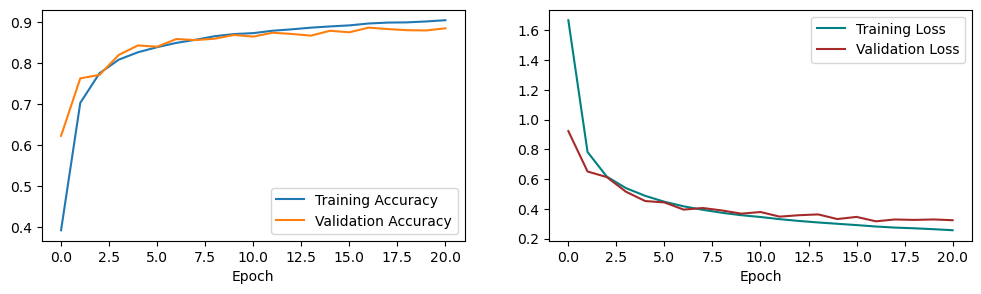

In [8]:
plt.subplots(figsize=(12,3))

plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training Loss', color='teal')
plt.plot(history['val_loss'], label='Validation Loss', color='brown')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## Define class names

In [9]:
class_names = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'
]

## Run classification evaluation

In [10]:
y_test_all = []
y_pred_all = []
total = 0
correct = 0

with torch.no_grad():
    for x_test, y_test in test_loader:
        outputs = mlp(x_test)
        predicted = argmax(outputs, axis = 1)
        y_pred_all.extend(predicted.numpy())
        y_test_all.extend(y_test.numpy())
        total += len(y_test)
        correct += (predicted == y_test).sum().item()

report = classification_report(y_test_all, y_pred_all, target_names=class_names, digits=4)
print(report)

              precision    recall  f1-score   support

 T-shirt/top     0.8450    0.8180    0.8313      1000
     Trouser     0.9917    0.9550    0.9730      1000
    Pullover     0.8518    0.6840    0.7587      1000
       Dress     0.8821    0.8980    0.8900      1000
        Coat     0.7283    0.8820    0.7978      1000
      Sandal     0.9512    0.9560    0.9536      1000
       Shirt     0.6731    0.6940    0.6834      1000
     Sneaker     0.9609    0.9100    0.9348      1000
         Bag     0.9699    0.9680    0.9690      1000
  Ankle boot     0.9195    0.9710    0.9446      1000

    accuracy                         0.8736     10000
   macro avg     0.8774    0.8736    0.8736     10000
weighted avg     0.8774    0.8736    0.8736     10000



## Visualize confusion matrix

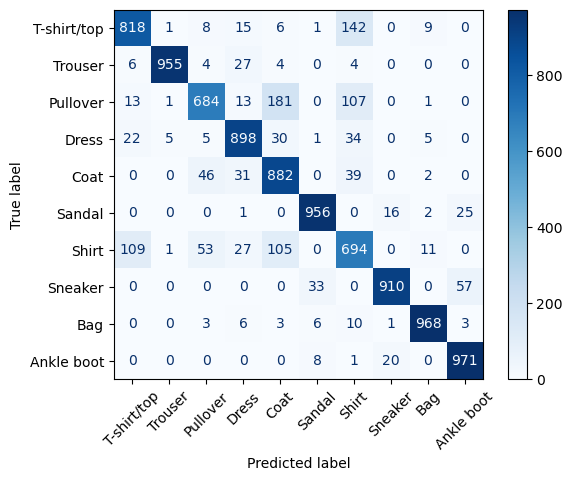

In [11]:
matrix = confusion_matrix(y_test_all, y_pred_all)
matrix_display = ConfusionMatrixDisplay(matrix, display_labels=class_names)
matrix_display.plot(cmap=plt.cm.Blues, xticks_rotation=45)